### Importing libraries

In [1]:
import re
import json
import keras
import string
import gensim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from hazm import word_tokenize
from keras.models import Model
from keras.datasets import imdb
from sklearn.utils import shuffle
from gensim.models.word2vec import Word2Vec
from keras.layers.embeddings import Embedding
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelBinarizer, StandardScaler
from keras.layers import LSTM, Activation, Dropout, Dense, Input

#### Reading the training data and converting it to dataframe

In [2]:
with open('train_final', encoding='utf-8') as json_file:
    df_data = []
    df_labels = []
    data = json.load(json_file)
    for i in range(len(data)):
        category_data = data[i]['input_list'][0]['post_list']
        category_labels = [data[i]['category']] * len(category_data)
        df_data += category_data
        df_labels += category_labels

    df = pd.DataFrame(
    {'Sentence': df_data,
     'Label': df_labels
    })

In [3]:
df = df.sample(frac=1).reset_index(drop=True)
df

,Sentence,Label
0,همه درها زندگیم به سوی خیر و برکت گشوده شده اند,positive
1,سرعت عالی همه چی عالییییی💛❤️💛💛❤️❤️💛❤️,positive
2,@irancell ‌ بفرستم شماره تلفنم خودتون چک میکنین,neutral
3,سلام ازاونجا که من همیشه کم شانس هستم افتادبرا...,positive
4,این بسته های جدید اینترنت چقد مزخرف شده، بسته ...,negative
...,...,...
9331,اقا حبیب و مرضیه,neutral
9332,اخه چرا در تعیین اسپانسر البسه پرسپولیس هم نقش...,negative
9333,مطالب جالبی دارید 🌹👍 دوست داری توی ۲۸ روز بدون...,positive
9334,با سلام.ایرانسل جان یه سوال.من یه شماره رند ای...,neutral


#### Removing mentions

In [4]:
# replace the matching strings
df = df.replace(to_replace ='(@[A-Za-z0-9]+)', value = '', regex = True)
df

,Sentence,Label
0,همه درها زندگیم به سوی خیر و برکت گشوده شده اند,positive
1,سرعت عالی همه چی عالییییی💛❤️💛💛❤️❤️💛❤️,positive
2,‌ بفرستم شماره تلفنم خودتون چک میکنین,neutral
3,سلام ازاونجا که من همیشه کم شانس هستم افتادبرا...,positive
4,این بسته های جدید اینترنت چقد مزخرف شده، بسته ...,negative
...,...,...
9331,اقا حبیب و مرضیه,neutral
9332,اخه چرا در تعیین اسپانسر البسه پرسپولیس هم نقش...,negative
9333,مطالب جالبی دارید 🌹👍 دوست داری توی ۲۸ روز بدون...,positive
9334,با سلام.ایرانسل جان یه سوال.من یه شماره رند ای...,neutral


#### Removing stopwords from persian nonverbal stopwords file alongside

In [5]:
def remove_stopwords(data, stopwords_file):
    with open(stopwords_file,encoding="utf-8") as f:
        stopwords = [list(map(str, line.split())) for line in f]
        stopwords = [word[0] for word in stopwords]
        print(stopwords)
        data['review without stopwords'] = data['Sentence'].apply(lambda x : ' '.join([word for word in x.split() if word not in (stopwords)]))
    return data

In [6]:
df = remove_stopwords(df, 'nonverbal')
df['clean_review'] = df['review without stopwords'].str.replace('[{}]'.format(string.punctuation), ' ')
df

['دیگران', 'همچنان', 'مدت', 'چیز', 'سایر', 'جا', 'طی', 'کل', 'کنونی', 'بیرون', 'مثلا', 'کامل', 'کاملا', 'آنکه', 'موارد', 'واقعی', 'امور', 'امورات', 'اکنون', 'بطور', 'به', 'بخشی', 'تحت', 'چگونه', 'عدم', 'نوعی', 'حاضر', 'وضع', 'مقابل', 'کنار', 'خویش', 'نگاه', 'درون', 'زمانی', 'بنابراین', 'بنابرین', 'تو', 'خیلی', 'بزرگ', 'خودش', 'جز', 'اینجا', 'مختلف', 'توسط', 'نوع', 'همچنین', 'آنجا', 'قبل', 'جناح', 'اینها', 'طور', 'شاید', 'ایشان', 'جهت', 'طریق', 'مانند', 'پیدا', 'ممکن', 'کسانی', 'جای', 'کسی', 'غیر', 'بی', 'قابل', 'درباره', 'جدید', 'وقتی', 'اخیر', 'چرا', 'بیش', 'روی', 'طرف', 'جریان', 'زیر', 'آنچه', 'البته', 'فقط', 'چیزی', 'چون', 'برابر', 'هنوز', 'بخش', 'زمینه', 'بین', 'بدون', 'استفاد', 'همان', 'نشان', 'بسیاری', 'بعد', 'عمل', 'روز', 'اعلام', 'چند', 'آنان', 'بلکه', 'امروز', 'تمام', 'بیشتر', 'آیا', 'برخی', 'علیه', 'دیگری', 'ویژه', 'گذشته', 'انجام', 'حتی', 'داده', 'راه', 'سوی', 'ولی', 'زمان', 'حال', 'تنها', 'بسیار', 'یعنی', 'عنوان', 'همین', 'هبچ', 'پیش', 'وی', 'یکی', 'اینکه', 'وجود', 'شما', '

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


,Sentence,Label,review without stopwords,clean_review
0,همه درها زندگیم به سوی خیر و برکت گشوده شده اند,positive,درها زندگیم خیر برکت گشوده شده اند,درها زندگیم خیر برکت گشوده شده اند
1,سرعت عالی همه چی عالییییی💛❤️💛💛❤️❤️💛❤️,positive,سرعت عالی چی عالییییی💛❤️💛💛❤️❤️💛❤️,سرعت عالی چی عالییییی💛❤️💛💛❤️❤️💛❤️
2,‌ بفرستم شماره تلفنم خودتون چک میکنین,neutral,‌ بفرستم شماره تلفنم خودتون چک میکنین,‌ بفرستم شماره تلفنم خودتون چک میکنین
3,سلام ازاونجا که من همیشه کم شانس هستم افتادبرا...,positive,سلام ازاونجا همیشه کم شانس هستم افتادبرای سال ...,سلام ازاونجا همیشه کم شانس هستم افتادبرای سال ...
4,این بسته های جدید اینترنت چقد مزخرف شده، بسته ...,negative,بسته های اینترنت چقد مزخرف شده، بسته ی سه گیگ ...,بسته های اینترنت چقد مزخرف شده، بسته ی سه گیگ ...
...,...,...,...,...
9331,اقا حبیب و مرضیه,neutral,اقا حبیب مرضیه,اقا حبیب مرضیه
9332,اخه چرا در تعیین اسپانسر البسه پرسپولیس هم نقش...,negative,اخه تعیین اسپانسر البسه پرسپولیس نقش دارید.بعد...,اخه تعیین اسپانسر البسه پرسپولیس نقش دارید بعد...
9333,مطالب جالبی دارید 🌹👍 دوست داری توی ۲۸ روز بدون...,positive,مطالب جالبی دارید 🌹👍 دوست داری توی ۲۸ گرسنگی ل...,مطالب جالبی دارید 🌹👍 دوست داری توی ۲۸ گرسنگی ل...
9334,با سلام.ایرانسل جان یه سوال.من یه شماره رند ای...,neutral,سلام.ایرانسل جان یه سوال.من یه شماره رند ایران...,سلام ایرانسل جان یه سوال من یه شماره رند ایران...


In [7]:
y = pd.get_dummies(df['Label']).values
sentences = df['clean_review']
X_train = sentences
Y_train = y

In [8]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

words_to_index = tokenizer.word_index

#### Constructing word2vec model

In [9]:
# Storing comments in list
comments = [comment for comment in df.Sentence]
sents = [word_tokenize(comment) for comment in comments]
model_w2v = Word2Vec(sentences=sents,  window=10, min_count=5, seed=42, workers=5)
model_w2v.save('word2vec.kv')
word2vec_kv = model_w2v.wv

#### Creating word2vec dictionary

In [12]:
import pickle
w2v_dict = dict()
for word in word2vec_kv.index2word:
    w2v_dict[word] = word2vec_kv[word]

In [14]:
with open('w2v_dict.p', 'wb') as fp:
    pickle.dump(w2v_dict, fp, protocol=pickle.HIGHEST_PROTOCOL)
with open('w2v_dict.p', 'rb') as fp:
    dataaa = pickle.load(fp)

In [15]:
dataaa['ارزان']

array([-0.06339327, -0.04114379,  0.09598345, -0.02475059,  0.04265553,
       -0.106383  ,  0.02191864,  0.03953272,  0.1282396 ,  0.09649935,
       -0.07495572, -0.08190611, -0.00550319, -0.05088764, -0.02368456,
       -0.03202795, -0.03246547, -0.09740015,  0.02705891, -0.04721256,
       -0.10779036,  0.02889222, -0.04959387,  0.00438482,  0.1125828 ,
        0.02967408, -0.03953763, -0.03824307, -0.02350415,  0.08929399,
       -0.05833072,  0.11438753,  0.04715329, -0.00628094,  0.01926469,
        0.08733738,  0.03996496, -0.01428705,  0.0273339 ,  0.06207437,
       -0.02028371,  0.03845913,  0.11357221,  0.01934522,  0.03912058,
       -0.01071374,  0.08371281, -0.01819216, -0.07302573,  0.06922083,
        0.08789821, -0.06484031,  0.04392163,  0.09539251, -0.00485883,
        0.01967665, -0.02455812, -0.00202661,  0.00090681, -0.10674209,
        0.03723292, -0.00221859,  0.09511156, -0.04620351,  0.02567847,
       -0.06847313, -0.03509353,  0.0124781 , -0.03716535, -0.03

#### Creating the embedding layer

In [12]:
word_to_vec_map = w2v_dict

maxLen = 15

vocab_len = len(words_to_index)
embed_vector_len = word_to_vec_map['سلام'].shape[0]

emb_matrix = np.zeros((vocab_len, embed_vector_len))

for word, index in words_to_index.items():
  try:
      embedding_vector = word_to_vec_map[word]
  except:
      embedding_vector = None
  if embedding_vector is not None:
    emb_matrix[index, :] = embedding_vector

embedding_layer = Embedding(input_dim=vocab_len,
                            output_dim=embed_vector_len,
                            input_length=maxLen,
                            weights = [emb_matrix],
                            trainable=False)

In [13]:
embedding_layer

#### Model structure function

In [14]:
def persian_tc(input_shape):

  X_indices = Input(input_shape)

  embeddings = embedding_layer(X_indices)

  X = LSTM(128, return_sequences=True)(embeddings)

  X = Dropout(0.5)(X)

  X = LSTM(64)(X)
  
  X = Dense(3, activation='softmax')(X)

  model = Model(inputs=X_indices, outputs=X)

  return model

In [15]:
model = persian_tc((maxLen,))

#### Tokenizing and padding the training data

In [16]:
X_train_indices = tokenizer.texts_to_sequences(X_train)

X_train_indices = pad_sequences(X_train_indices, maxlen=maxLen, padding='post')
X_train_indices.shape

(9336, 15)

In [17]:
adam = keras.optimizers.adam_v2.Adam(learning_rate = 0.001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [18]:
X_train_indices, Y_train = shuffle(X_train_indices, Y_train)

In [19]:
checkpoint_filepath = 'W_w2v'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [20]:
history = model.fit(X_train_indices,
                    Y_train,
                    validation_split=0.2,
                    callbacks=[model_checkpoint_callback],
                    batch_size=32,
                    epochs=50)

Epoch 1/50
234/234 [==============================] - 11s 28ms/step - loss: 0.9564 - accuracy: 0.5344 - val_loss: 0.9187 - val_accuracy: 0.5824
Epoch 2/50
234/234 [==============================] - 7s 30ms/step - loss: 0.9048 - accuracy: 0.5803 - val_loss: 0.9052 - val_accuracy: 0.5766
Epoch 3/50
234/234 [==============================] - 7s 30ms/step - loss: 0.8949 - accuracy: 0.5826 - val_loss: 0.9227 - val_accuracy: 0.5744
Epoch 4/50
234/234 [==============================] - 7s 30ms/step - loss: 0.8845 - accuracy: 0.5892 - val_loss: 0.8623 - val_accuracy: 0.5980
Epoch 5/50
234/234 [==============================] - 9s 37ms/step - loss: 0.8631 - accuracy: 0.6014 - val_loss: 0.8477 - val_accuracy: 0.5985
Epoch 6/50
234/234 [==============================] - 10s 42ms/step - loss: 0.8571 - accuracy: 0.6054 - val_loss: 0.8902 - val_accuracy: 0.5910
Epoch 7/50
234/234 [==============================] - 9s 38ms/step - loss: 0.8397 - accuracy: 0.6172 - val_loss: 0.8465 - val_accuracy: 0.60

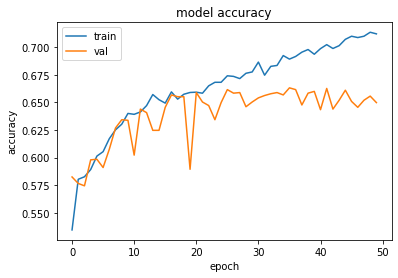

In [24]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

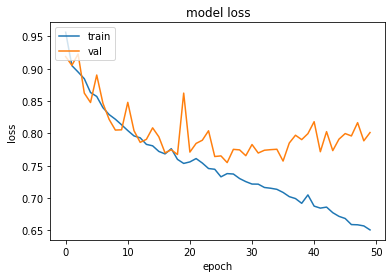

In [25]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [27]:
checkpoint_filepath = "W_w2v/W_w2v"
model.load_weights(checkpoint_filepath)

In [28]:
with open('validation_final', encoding='utf-8') as json_file:
    df_data = []
    df_labels = []
    data = json.load(json_file)
    for i in range(len(data)):
        category_data = data[i]['input_list'][0]['post_list']
        category_labels = [data[i]['category']] * len(category_data)
        df_data += category_data
        df_labels += category_labels

    df_val = pd.DataFrame(
    {'Sentence': df_data,
     'Label': df_labels
    })

In [29]:
df_val = df_val.replace(to_replace ='(@[A-Za-z0-9]+)', value = '', regex = True)

df_val = remove_stopwords(df_val, 'nonverbal')
df_val['clean_review'] = df_val['review without stopwords'].str.replace('[{}]'.format(string.punctuation), ' ')

y_val = pd.get_dummies(df_val['Label']).values
sentences = df_val['clean_review']

X_val = sentences
Y_val = y_val

X_val_indices = tokenizer.texts_to_sequences(X_val)

X_val_indices = pad_sequences(X_val_indices, maxlen=maxLen, padding='post')
X_val_indices.shape

['دیگران', 'همچنان', 'مدت', 'چیز', 'سایر', 'جا', 'طی', 'کل', 'کنونی', 'بیرون', 'مثلا', 'کامل', 'کاملا', 'آنکه', 'موارد', 'واقعی', 'امور', 'امورات', 'اکنون', 'بطور', 'به', 'بخشی', 'تحت', 'چگونه', 'عدم', 'نوعی', 'حاضر', 'وضع', 'مقابل', 'کنار', 'خویش', 'نگاه', 'درون', 'زمانی', 'بنابراین', 'بنابرین', 'تو', 'خیلی', 'بزرگ', 'خودش', 'جز', 'اینجا', 'مختلف', 'توسط', 'نوع', 'همچنین', 'آنجا', 'قبل', 'جناح', 'اینها', 'طور', 'شاید', 'ایشان', 'جهت', 'طریق', 'مانند', 'پیدا', 'ممکن', 'کسانی', 'جای', 'کسی', 'غیر', 'بی', 'قابل', 'درباره', 'جدید', 'وقتی', 'اخیر', 'چرا', 'بیش', 'روی', 'طرف', 'جریان', 'زیر', 'آنچه', 'البته', 'فقط', 'چیزی', 'چون', 'برابر', 'هنوز', 'بخش', 'زمینه', 'بین', 'بدون', 'استفاد', 'همان', 'نشان', 'بسیاری', 'بعد', 'عمل', 'روز', 'اعلام', 'چند', 'آنان', 'بلکه', 'امروز', 'تمام', 'بیشتر', 'آیا', 'برخی', 'علیه', 'دیگری', 'ویژه', 'گذشته', 'انجام', 'حتی', 'داده', 'راه', 'سوی', 'ولی', 'زمان', 'حال', 'تنها', 'بسیار', 'یعنی', 'عنوان', 'همین', 'هبچ', 'پیش', 'وی', 'یکی', 'اینکه', 'وجود', 'شما', '

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  after removing the cwd from sys.path.


(450, 15)

In [30]:
model.evaluate(X_val_indices, Y_val)

15/15 [==============================] - 0s 6ms/step - loss: 0.8500 - accuracy: 0.5867


[0.8499943614006042, 0.5866666436195374]